In [1]:
# load modules
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import r2_score
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
# load data
train_df  = pd.read_csv('./input/train.csv')
test_df  = pd.read_csv('./input/test.csv')

In [3]:
print(train_df.shape)
print(test_df.shape)

(4209, 378)
(4209, 377)


In [4]:
# get train_y, test ids and unite datasets to perform
train_y = train_df['y']
train_df.drop('y', axis = 1, inplace = True)
test_ids = test_df.ID.values
all_df = pd.concat([train_df,test_df], axis = 0)

# ...one hot encoding of categorical variables
categorical =  ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]
for f in categorical:
    dummies = pd.get_dummies(all_df[f], prefix = f, prefix_sep = '_')
    all_df = pd.concat([all_df, dummies], axis = 1)

# drop original categorical features
all_df.drop(categorical, axis = 1, inplace = True)

In [5]:
# get feature dataset for test and training        
train_X = all_df.drop(["ID"], axis=1).iloc[:len(train_df),:]
test_X = all_df.drop(["ID"], axis=1).iloc[len(train_df):,:]
predictors = train_X.columns

# transfrom y to loy(y+1) since it is skewed

In [19]:
#save_train_df = pd.concat([train_X,train_y],axis=1)
#save_train_df.to_csv('./input/processed_train.csv',index=False)


In [21]:
#test_X.to_csv('./input/processed_test.csv',index=False)

In [6]:
log_train_y = np.log(train_y+1)


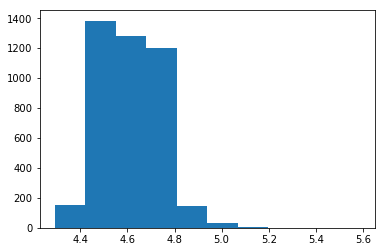

In [7]:
%matplotlib inline
plt.hist(log_train_y)
train_y = log_train_y

# do some feature engineering
generate a new feature according to https://www.kaggle.com/headsortails/mercedas-update2-intrinsic-noise

In [57]:
#X10-X395
train_data = pd.concat([train_X,train_y],axis=1)
train_data = train_data.sort_values( by= 'y')
train_data['diff'] = 0
ref_row = train_data.iloc[0]
predictors = [item for item in train_data.columns if item !='y']
for ind,row in train_data.iterrows():
    diff = 0.0
    for ind_feat in predictors:
        feat = ind_feat
        diff += np.abs(ref_row[feat]-row[feat])
    #row['diff'] = diff
    train_data.set_value(ind,'diff',diff)


In [59]:
test_X['diff'] = 0
for ind,row in test_X.iterrows():
    diff = 0.0
    for ind_feat in predictors:
        diff += np.abs(ref_row[ind_feat]-row[ind_feat])
    test_X.set_value(ind,'diff',diff)

In [60]:
# normalization for the 'diff' feature
train_data['diff'] = (train_data['diff']-train_data['diff'].min())/(train_data['diff'].max()-train_data['diff'].min())
test_X['diff'] = (test_X['diff']-test_X['diff'].min())/(test_X['diff'].max()-test_X['diff'].min())

In [61]:

train_X = train_data[predictors]
train_y = train_data['y']

# use elastic net for modelling 

In [11]:
# Let's perform a cross-validation to find the best combination of alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [12]:
cv_model.fit(train_X, train_y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [13]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00314540
Optimal l1_ratio: 1.000
Number of iterations 603


In [14]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(train_X, train_y)

ElasticNet(alpha=0.003145399303881424, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=603, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [15]:
# r2 score on training dataset
print(r2_score(train_y, model.predict(train_X)))

0.586978770942


In [16]:
preds = model.predict(test_X)
df_sub = pd.DataFrame({'ID': test_ids, 'y': preds})
df_sub.to_csv('elnet_submission_dummies.csv', index=False)

68 features, reduction of 100.00%


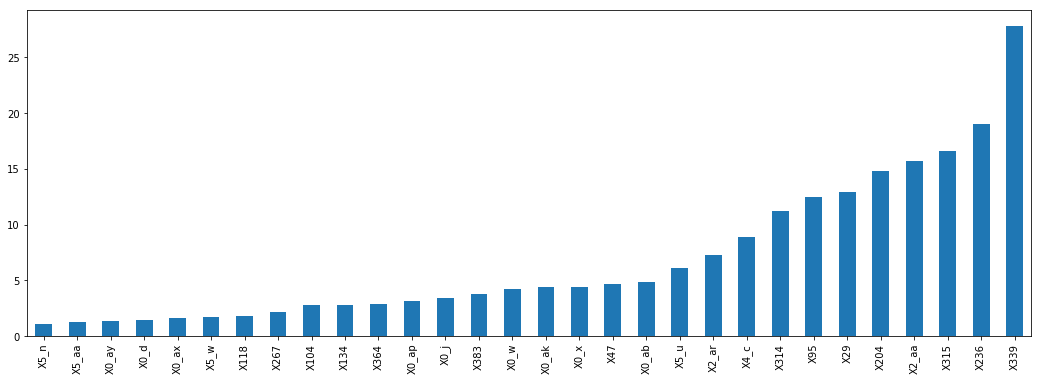

In [17]:
feature_importance = pd.Series(index = train_X.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

# use xgboost modeling

In [13]:
def R2score(pred,dtrain):
    labels = dtrain.get_label()
    return 'score',metrics.r2_score(labels,pred)
    
def modelfit(alg, dtrain, ytrain , predictors,test, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          feval=R2score,maximize = True, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
        print('num_rounds %f'%cvresult.shape[0])
    #Fit the algorithm on the data
    alg.fit(dtrain, ytrain,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
        
    #Print model report:
    print ("\nModel Report")
    print ("R2 : %.4g" % metrics.r2_score(ytrain, dtrain_predictions))

    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    
  
    #dtest = xgb.DMatrix(test[predictors].values)
    #y_pred = alg.predict(test[predictors].values)
    
    #output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
    #output.to_csv('submission_baseLine.csv', index=False)


In [14]:


#Choose all predictors except target & IDcols
test_X['ID'] = test_ids
predictors = test_X.dtypes.index[test_X.columns!='ID']
xgb1 = XGBRegressor(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'reg:linear',
                     #base_score = y_mean,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
                     
modelfit(xgb1,train_X.values, train_y, predictors,test_X)


    test-rmse-mean  test-rmse-std  test-score-mean  test-score-std  \
0         3.704894       0.006779      -953.403407       70.112572   
1         3.334949       0.006652      -772.320300       56.841897   
2         3.001877       0.006496      -625.560103       45.988506   
3         2.702176       0.006475      -506.695760       37.270657   
4         2.432497       0.006368      -410.414932       30.206959   
5         2.189717       0.006240      -332.390063       24.501052   
6         1.971291       0.006071      -269.193732       19.839446   
7         1.774682       0.005836      -217.981671       16.037158   
8         1.597728       0.005722      -176.487473       12.980142   
9         1.438524       0.005607      -142.877370       10.512367   
10        1.295288       0.005454      -115.648803        8.490354   
11        1.166481       0.005447       -93.601451        6.879439   
12        1.050450       0.005324       -75.716496        5.575571   
13        0.946117  

# try the magic feature
https://www.kaggle.com/robertoruiz/a-magic-feature/code

In [46]:
print(train_df.head())
train_df['y'] = train_y

   ID  X0 X1  X2 X3 X4 X5 X6 X8  X10  ...   X375  X376  X377  X378  X379  \
0   0   k  v  at  a  d  u  j  o    0  ...      0     0     1     0     0   
1   6   k  t  av  e  d  y  l  o    0  ...      1     0     0     0     0   
2   7  az  w   n  c  d  x  j  x    0  ...      0     0     0     0     0   
3   9  az  t   n  f  d  x  l  e    0  ...      0     0     0     0     0   
4  13  az  v   n  f  d  h  d  n    0  ...      0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 377 columns]


In [7]:
x0_y_mean = train_df.groupby(by = 'X0')['y'].mean()

In [57]:
def assign_x0_mean(row):
    if row['X0'] in x0_y_mean:
        row['x0_y_mean'] = x0_y_mean[row['X0']]
    else:
        row['x0_y_mean'] = None
    return row['x0_y_mean']
    
   

In [47]:
#train_df['x0_y_mean'] = -1
train_df['x0_y_mean'] = train_df.apply(assign_x0_mean,axis=1)

In [63]:
test_df['x0_y_mean'] = test_df.apply(assign_x0_mean,axis=1)
test_df['x0_y_mean'] = test_df['x0_y_mean'].fillna(test_df['x0_y_mean'].mean())

In [67]:
# concatenate the features with train_X
train_X['x0_y_mean'] = train_df['x0_y_mean'].values
test_X['x0_y_mean'] = test_df['x0_y_mean'].values


Model Report
R2 : 0.634


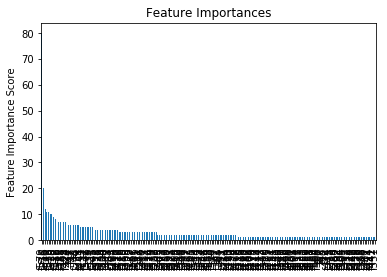

In [73]:
#Choose all predictors except target & IDcols
test_X['ID'] = test_ids
predictors = test_X.dtypes.index[test_X.columns!='ID']
xgb1 = XGBRegressor(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'reg:linear',
                     #base_score = y_mean,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
                     
modelfit(xgb1,train_X.values, train_y, predictors,test_X)


In [77]:
#upload the feature directly w
ret_df = test_X[['ID','x0_y_mean']]
ret_df.columns=['id','y']
ret_df.to_csv('test.csv',index= False)

# tuning the parameter for xgboost

In [16]:

#Choose all predictors except target & IDcols
test_X['ID'] = test_ids
predictors = test_X.dtypes.index[test_X.columns!='ID']
xgb1 = XGBRegressor(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     #subsample=0.8,
                     #colsample_bytree=0.8,
                     objective= 'reg:linear',
                     #base_score = y_mean,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
                     
modelfit(xgb1,train_X.values, train_y, predictors,test_X)


    test-rmse-mean  test-rmse-std  test-score-mean  test-score-std  \
0         3.704793       0.006541      -953.348681       70.073531   
1         3.334759       0.006440      -772.228560       56.787973   
2         3.001736       0.006368      -625.503876       46.024803   
3         2.702028       0.006322      -506.642790       37.305061   
4         2.432281       0.006054      -410.342282       30.204074   
5         2.189516       0.005828      -332.325931       24.454040   
6         1.971039       0.005640      -269.122202       19.798158   
7         1.774428       0.005483      -217.918702       16.028442   
8         1.597501       0.005355      -176.437004       12.976398   
9         1.438266       0.005232      -142.825630       10.506010   
10        1.295000       0.005135      -115.598172        8.503859   
11        1.166086       0.005094       -93.537989        6.883040   
12        1.050095       0.005061       -75.664571        5.571442   
13        0.945754  

In [20]:
#continue increase the power of the model 
param_test = {
 'max_depth':[2,3,4,5,6]
}
gsearch = GridSearchCV(estimator = XGBRegressor( 
    learning_rate =0.1,
    n_estimators=71,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    objective= 'reg:linear',
    nthread=3,
    scale_pos_weight=1,
    seed=27), 
param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch.fit(train_X.values,train_y)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

E:\softwareinstallion\anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.00549, std: 0.00114, params: {'max_depth': 2},
  mean: -0.00546, std: 0.00114, params: {'max_depth': 3},
  mean: -0.00547, std: 0.00114, params: {'max_depth': 4},
  mean: -0.00550, std: 0.00115, params: {'max_depth': 5},
  mean: -0.00552, std: 0.00114, params: {'max_depth': 6}],
 {'max_depth': 3},
 -0.0054631687439152055)

In [21]:
xgb1 = XGBRegressor(
                     learning_rate =0.1,
                     n_estimators=500,
                     max_depth=3,
                     min_child_weight=1,
                     gamma=0,
                     #subsample=0.8,
                     #colsample_bytree=0.8,
                     objective= 'reg:linear',
                     #base_score = y_mean,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
                     
modelfit(xgb1,train_X.values, train_y, predictors,test_X)


    test-rmse-mean  test-rmse-std  test-score-mean  test-score-std  \
0         3.704793       0.006541      -953.348681       70.073531   
1         3.334759       0.006440      -772.228560       56.787973   
2         3.001736       0.006368      -625.503876       46.024803   
3         2.702028       0.006322      -506.642790       37.305061   
4         2.432281       0.006054      -410.342282       30.204074   
5         2.189516       0.005828      -332.325931       24.454040   
6         1.971039       0.005640      -269.122202       19.798158   
7         1.774428       0.005483      -217.918702       16.028442   
8         1.597501       0.005355      -176.437004       12.976398   
9         1.438266       0.005232      -142.825630       10.506010   
10        1.295000       0.005135      -115.598172        8.503859   
11        1.166086       0.005094       -93.537989        6.883040   
12        1.050095       0.005061       -75.664571        5.571442   
13        0.945754  

In [29]:

y_pred = xgb1.predict(test_X[predictors].values)
#need to transform the y_pred to original scale
y_pred = np.exp(y_pred)-1
output = pd.DataFrame({'id': test_X['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('submission_baseLine_9.csv', index=False)

# 从上面的结果来看，应该继续调参

In [23]:
#continue increase the power of the model 
param_test = {
 'min_child_weight':[0.5,0.8,1,1.2,1.5]
}
gsearch = GridSearchCV(estimator = XGBRegressor( 
    learning_rate =0.1,
    n_estimators=81,
    max_depth=3,
    #min_child_weight=1,
    gamma=0,
    objective= 'reg:linear',
    nthread=3,
    scale_pos_weight=1,
    seed=27), 
param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch.fit(train_X.values,train_y)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

E:\softwareinstallion\anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.00547, std: 0.00112, params: {'min_child_weight': 0.5},
  mean: -0.00547, std: 0.00112, params: {'min_child_weight': 0.8},
  mean: -0.00547, std: 0.00112, params: {'min_child_weight': 1},
  mean: -0.00547, std: 0.00111, params: {'min_child_weight': 1.2},
  mean: -0.00547, std: 0.00111, params: {'min_child_weight': 1.5}],
 {'min_child_weight': 0.5},
 -0.0054655396990520872)

In [24]:
xgb1 = XGBRegressor(
                     learning_rate =0.1,
                     n_estimators=500,
                     max_depth=3,
                     min_child_weight=0.5,
                     gamma=0,
                     #subsample=0.8,
                     #colsample_bytree=0.8,
                     objective= 'reg:linear',
                     #base_score = y_mean,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
                     
modelfit(xgb1,train_X.values, train_y, predictors,test_X)

    test-rmse-mean  test-rmse-std  test-score-mean  test-score-std  \
0         3.704793       0.006541      -953.348681       70.073531   
1         3.334759       0.006440      -772.228560       56.787973   
2         3.001736       0.006368      -625.503876       46.024803   
3         2.702028       0.006322      -506.642790       37.305061   
4         2.432281       0.006054      -410.342282       30.204074   
5         2.189516       0.005828      -332.325931       24.454040   
6         1.971039       0.005640      -269.122202       19.798158   
7         1.774428       0.005483      -217.918702       16.028442   
8         1.597501       0.005355      -176.437004       12.976398   
9         1.438266       0.005232      -142.825630       10.506010   
10        1.295000       0.005135      -115.598172        8.503859   
11        1.166086       0.005094       -93.537989        6.883040   
12        1.050095       0.005061       -75.664571        5.571442   
13        0.945754  

In [25]:
#continue increase the power of the model 
param_test = {
 'gamma':[0,0.5,0.8,1]
}
gsearch = GridSearchCV(estimator = XGBRegressor( 
    learning_rate =0.1,
    n_estimators=81,
    max_depth=3,
    min_child_weight=0.5,
    gamma=0,
    objective= 'reg:linear',
    nthread=3,
    scale_pos_weight=1,
    seed=27), 
param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch.fit(train_X.values,train_y)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

E:\softwareinstallion\anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.00593, std: 0.00106, params: {'gamma': 0.5},
  mean: -0.00617, std: 0.00110, params: {'gamma': 0.8},
  mean: -0.00633, std: 0.00109, params: {'gamma': 1},
  mean: -0.00658, std: 0.00102, params: {'gamma': 1.2},
  mean: -0.00683, std: 0.00106, params: {'gamma': 1.5}],
 {'gamma': 0.5},
 -0.0059342727050987424)

In [28]:
xgb1 = XGBRegressor(
                     learning_rate =0.1,
                     n_estimators=500,
                     max_depth=3,
                     min_child_weight=0.5,
                     gamma=0,
                     #subsample=0.8,
                     #colsample_bytree=0.8,
                     objective= 'reg:linear',
                     #base_score = y_mean,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
                     
modelfit(xgb1,train_X.values, train_y, predictors,test_X)

    test-rmse-mean  test-rmse-std  test-score-mean  test-score-std  \
0         3.704793       0.006541      -953.348681       70.073531   
1         3.334759       0.006440      -772.228560       56.787973   
2         3.001736       0.006368      -625.503876       46.024803   
3         2.702028       0.006322      -506.642790       37.305061   
4         2.432281       0.006054      -410.342282       30.204074   
5         2.189516       0.005828      -332.325931       24.454040   
6         1.971039       0.005640      -269.122202       19.798158   
7         1.774428       0.005483      -217.918702       16.028442   
8         1.597501       0.005355      -176.437004       12.976398   
9         1.438266       0.005232      -142.825630       10.506010   
10        1.295000       0.005135      -115.598172        8.503859   
11        1.166086       0.005094       -93.537989        6.883040   
12        1.050095       0.005061       -75.664571        5.571442   
13        0.945754  

# try stacking methods

https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [6]:
# Some useful parameters which will come in handy later on
ntrain = train_X.shape[0]
ntest = test_X.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED).split(train_X)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

In [7]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    # since kf is a generator object, and it can't be reused, so we should add this line in this function
    kf = KFold(n_splits=NFOLDS, random_state=SEED).split(train_X)
    for i,(train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test[:] = oof_test_skf.mean(axis=0)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
rf_params = {
    #'n_jobs': -1,
    'n_estimators': 500,
     #'warm_start': True, 
     #'max_features': 0.2,
    #'max_depth': 6,
    #'min_samples_leaf': 2,
    #'max_features' : 'sqrt',
    #'verbose': 0
}
svr_params={
    'C':1,
    'epsilon':0.1,
    'kernel':'rbf',
}

In [9]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
#et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
#ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
#gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
#svr = SklearnHelper(clf=SVR, seed=SEED,params = svr_params)

In [10]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train_y.ravel()
train = train_X[predictors]
x_train = train.values # Creates an array of the train data
x_test = test_X[predictors].values # Creats an array of the test data

In [11]:
# Create our OOF train and test predictions. These base results will be used as new features

rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
#svr_oof_train, svr_oof_test = get_oof(svr,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [157]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
      'SVR': svr_oof_train.ravel()
    })
base_predictions_train.shape

(4209, 2)

In [162]:
x_train = np.concatenate(( rf_oof_train,svr_oof_train), axis=1)
x_test = np.concatenate(( rf_oof_test,svr_oof_test), axis=1)

In [6]:
list(test_df.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [14]:
xgb1._Booster.save_model('tst.model')

In [15]:
xgb1.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 56,
 'nthread': 4,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8}

In [20]:
xgb2 = XGBRegressor()
#booster = Booster()
#xgb2._Booster = 
from xgboost.sklearn import Booster
booster = Booster()
booster.load_model('tst.model')
xgb2._Booster = booster

In [25]:
import  pickle
pickle.dump(xgb1,open('xgb1.model','wb'))

In [27]:
xgb3 = pickle.load(open('xgb1.model','rb'))
xgb3.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 56,
 'nthread': 4,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8}

In [7]:
import numpy as np
a = np.array([1,2,3,4,6])
b=a.ravel()
print(b.any())

True
